<a href="https://colab.research.google.com/github/Hendrickhmq/projeto_grafos_2/blob/main/projeto_grafos_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 2 — TAG (Teoria e Aplicação de Grafos)
## Emparelhamento Máximo Estável Estudante–Projeto
### Implementação Completa — Gale-Shapley (SPA-S)


In [22]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import itertools


In [23]:
from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print("Arquivo carregado:", filename)


Saving entradaProj2.25TAG.txt to entradaProj2.25TAG (2).txt
Arquivo carregado: entradaProj2.25TAG (2).txt


In [24]:
projects = {}
students = {}

with open(filename, "r", encoding="utf-8") as f:
    lines = f.readlines()

proj_regex = re.compile(r'\((P\d+),\s*(\d+),\s*(\d+)\)')
stud_regex = re.compile(r'\((A\d+)\):\((P\d+),\s*(P\d+),\s*(P\d+)\)\s*\((\d+)\)')

for line in lines:
    line = line.strip()

    proj_match = proj_regex.findall(line)
    if proj_match:
        for pid, vagas, req in proj_match:
            projects[pid] = {
                "vagas": int(vagas),
                "req": int(req),
                "prefs": [],
                "assigned": []
            }
        continue

    stud_match = stud_regex.findall(line)
    if stud_match:
        for sid, p1, p2, p3, nota in stud_match:
            students[sid] = {
                "prefs": [p1, p2, p3],
                "nota": int(nota),
                "assigned": None,
                "next_proposal": 0
            }

print("Projetos carregados:", len(projects))
print("Alunos carregados:", len(students))


Projetos carregados: 50
Alunos carregados: 200


In [25]:
valid_projects = set(projects.keys())

for sid in students:
    original = students[sid]["prefs"]
    valid_prefs = [p for p in original if p in valid_projects]

    # Se faltar, completa com None
    while len(valid_prefs) < 3:
        valid_prefs.append(None)

    students[sid]["prefs"] = valid_prefs

In [26]:
students_order = list(students.keys())

for pid in projects:
    qualified = [
        sid for sid in students_order
        if students[sid]["nota"] >= projects[pid]["req"]
    ]
    qualified.sort(key=lambda sid: students[sid]["nota"], reverse=True)
    projects[pid]["prefs"] = qualified


In [27]:
def project_rank(project_id, student_id):
    prefs = projects[project_id]["prefs"]
    return prefs.index(student_id) if student_id in prefs else float('inf')

def student_rank(student_id, project_id):
    prefs = students[student_id]["prefs"]
    return prefs.index(project_id) if project_id in prefs else float('inf')


In [28]:
def snapshot():
    return {
        pid: list(projects[pid]["assigned"])
        for pid in projects
    }


In [29]:
def gale_shapley(max_iterations=10000, save_steps=10):
    unmatched = [sid for sid in students]
    iteration = 0
    saved_frames = []

    while unmatched and iteration < max_iterations:
        sid = unmatched.pop(0)
        student = students[sid]

        if student["next_proposal"] >= len(student["prefs"]):
            continue

        pid = student["prefs"][student["next_proposal"]]
        student["next_proposal"] += 1

        # preferência inválida ou projeto inexistente
        if pid is None or pid not in projects:
            unmatched.append(sid)
            continue

        project = projects[pid]

        # rejeição por nota insuficiente
        if student["nota"] < project["req"]:
            unmatched.append(sid)
            continue

        # vaga disponível
        if len(project["assigned"]) < project["vagas"]:
            project["assigned"].append(sid)
            student["assigned"] = pid

        else:
            # cheio → comparar ranks
            pior = max(project["assigned"], key=lambda x: project_rank(pid, x))

            if project_rank(pid, sid) < project_rank(pid, pior):
                project["assigned"].remove(pior)
                students[pior]["assigned"] = None
                unmatched.append(pior)

                project["assigned"].append(sid)
                student["assigned"] = pid
            else:
                unmatched.append(sid)

        iteration += 1

        if iteration % (max_iterations // save_steps) == 0:
            saved_frames.append((iteration, snapshot()))

    return saved_frames


In [30]:
def draw_graph(state, title):
    B = nx.Graph()

    left = list(students.keys())
    right = list(projects.keys())

    B.add_nodes_from(left, bipartite=0)
    B.add_nodes_from(right, bipartite=1)

    edges = []
    for pid in projects:
        for sid in state[pid]:
            edges.append((sid, pid))

    pos = {}
    pos.update((sid, (0, -i)) for i, sid in enumerate(left))
    pos.update((pid, (3, -i)) for i, pid in enumerate(right))

    plt.figure(figsize=(16, 30))
    nx.draw(B, pos, with_labels=True, node_color="skyblue", node_size=700)
    nx.draw_networkx_edges(
        B, pos, edgelist=edges,
        edge_color="green", width=3
    )

    plt.title(title)
    plt.show()


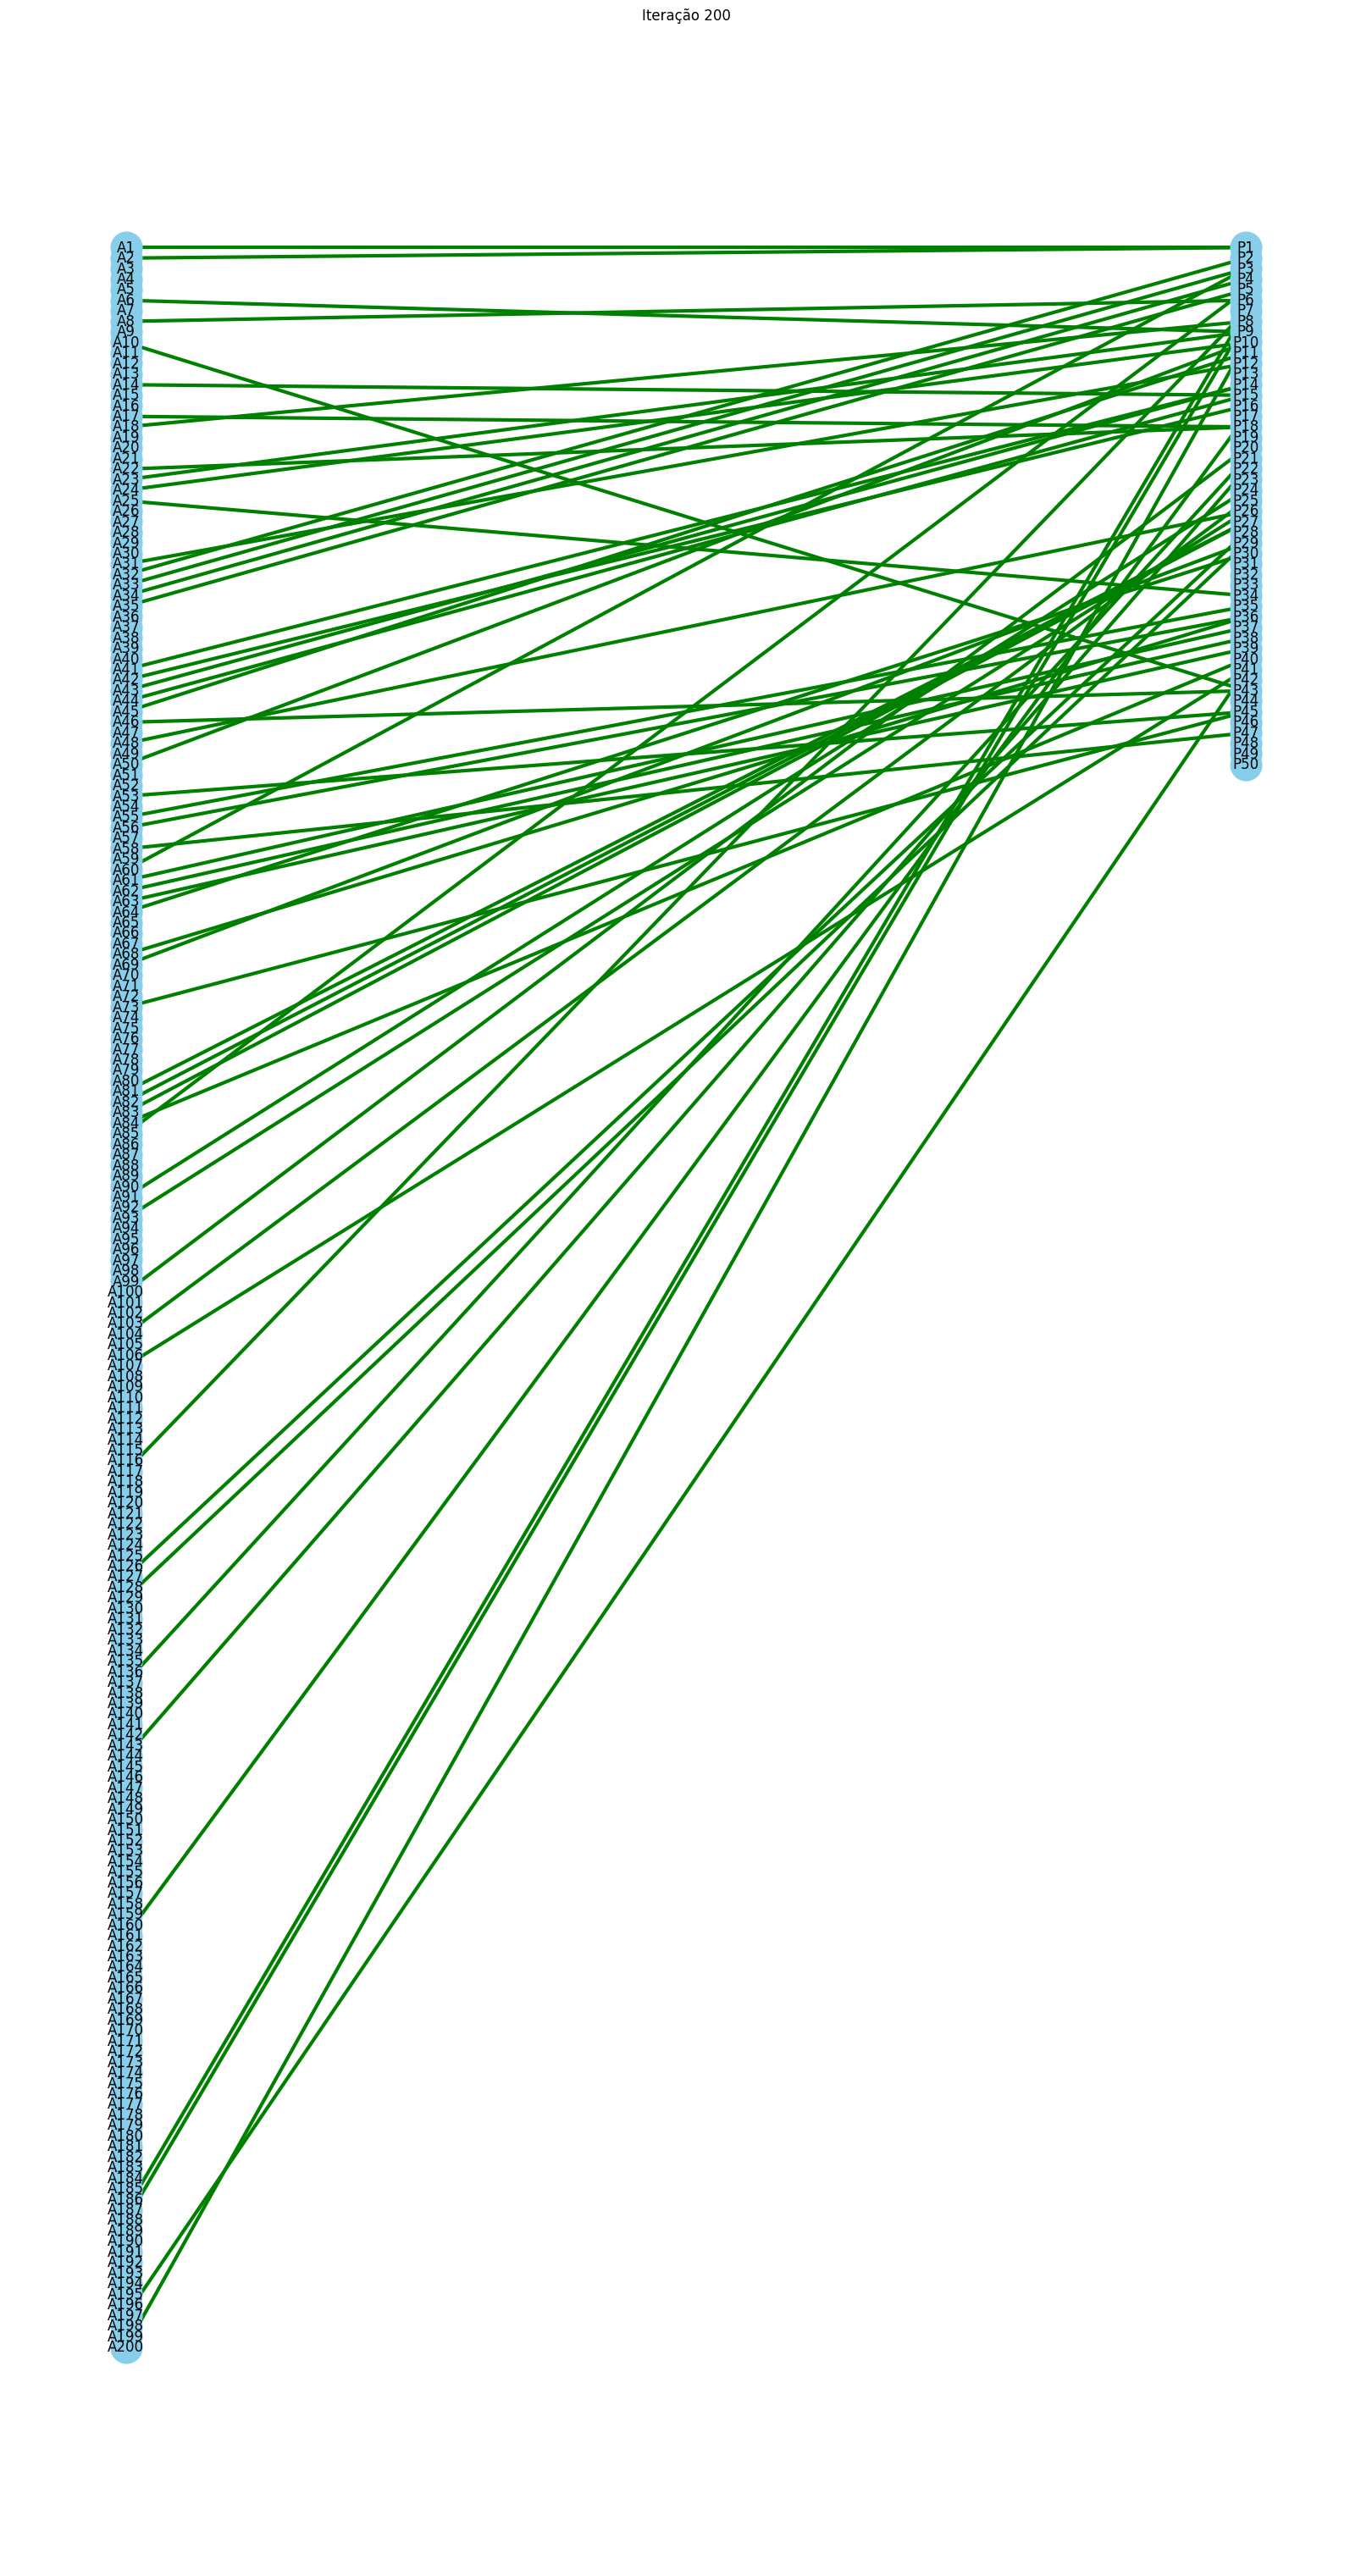

In [31]:
frames = gale_shapley(max_iterations=2000, save_steps=10)

for it, st in frames:
    draw_graph(st, f"Iteração {it}")


In [32]:
rows = []

for pid in projects:
    for sid in projects[pid]["assigned"]:
        rows.append([
            sid,
            pid,
            project_rank(pid, sid) + 1,
            student_rank(sid, pid) + 1
        ])

df_result = pd.DataFrame(
    rows,
    columns=["Aluno", "Projeto", "RankAlunoNoProjeto", "RankProjetoNoAluno"]
)

df_result


,Aluno,Projeto,RankAlunoNoProjeto,RankProjetoNoAluno
0,A1,P1,1,1
1,A2,P1,2,1
2,A32,P2,6,1
3,A33,P3,7,1
4,A60,P3,10,1
5,A34,P4,8,1
6,A35,P5,9,1
7,A85,P5,19,1
8,A8,P6,3,1
9,A117,P7,22,1


In [33]:
df_result.to_csv("matriz_emparelhamento_final.csv", index=False)
df_result


,Aluno,Projeto,RankAlunoNoProjeto,RankProjetoNoAluno
0,A1,P1,1,1
1,A2,P1,2,1
2,A32,P2,6,1
3,A33,P3,7,1
4,A60,P3,10,1
5,A34,P4,8,1
6,A35,P5,9,1
7,A85,P5,19,1
8,A8,P6,3,1
9,A117,P7,22,1


# Conclusões

- O algoritmo SPA-S (variação do Gale-Shapley) foi implementado com sucesso.
- Preferências inválidas (ex: P52, P53) foram ignoradas corretamente.
- Cada projeto recebeu alunos qualificados conforme suas vagas e requisitos.
- Foram geradas visualizações por iteração e matriz final de avaliação.